<a href="https://colab.research.google.com/github/sm1899/Ml-algos-from-Scratch/blob/main/CNN/cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importint the libreies

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import plotly.graph_objects as go


In [ ]:
# # device setting
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [ ]:
# Downloading the MNIST data
transform = transforms.Compose([transforms.ToTensor()])#transforms.Normalize((0.5,), (0.5,))
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# hyper parameters
lr = .001
epochs = 10
batch_size = 32

# *Experiment one*

In [ ]:
# preparing train test and validation

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# defining the CNN Architire
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # conv layer one with pooling

        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv layer two with pooling

        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv layer three with pooling

        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected output layer

        self.fc = nn.Linear(4 * 3 * 3, 10)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # print("Size after Conv3",x.size())

        # Flatten the conv output

        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)
        # x = self.softmax(x)
        return x



In [ ]:
# model initialaization with  loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# list to store losses
train_losses = []
val_losses = []
train_acc  = []
val_acc = []

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=36, out_features=10, bias=True)
)


In [ ]:
# no of trainable parametres
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

4726


In [ ]:
# Training
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader, 1):
        labels = labels.view(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1))
            epoch_val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)

    print('Epoch', epoch + 1, '/', epochs, f'Training Loss: {avg_train_loss:.4f}, Training Acc: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')


Epoch 1 / 10 Training Loss: 0.3892, Training Acc: 87.34%, Validation Loss: 0.1470, Validation Acc: 95.25%
Epoch 2 / 10 Training Loss: 0.1241, Training Acc: 96.23%, Validation Loss: 0.1059, Validation Acc: 96.63%
Epoch 3 / 10 Training Loss: 0.0934, Training Acc: 97.14%, Validation Loss: 0.0821, Validation Acc: 97.30%
Epoch 4 / 10 Training Loss: 0.0793, Training Acc: 97.55%, Validation Loss: 0.0793, Validation Acc: 97.50%
Epoch 5 / 10 Training Loss: 0.0690, Training Acc: 97.92%, Validation Loss: 0.0647, Validation Acc: 97.92%
Epoch 6 / 10 Training Loss: 0.0606, Training Acc: 98.12%, Validation Loss: 0.0685, Validation Acc: 97.82%
Epoch 7 / 10 Training Loss: 0.0563, Training Acc: 98.31%, Validation Loss: 0.0628, Validation Acc: 97.97%
Epoch 8 / 10 Training Loss: 0.0509, Training Acc: 98.42%, Validation Loss: 0.0461, Validation Acc: 98.48%
Epoch 9 / 10 Training Loss: 0.0468, Training Acc: 98.51%, Validation Loss: 0.0569, Validation Acc: 98.12%
Epoch 10 / 10 Training Loss: 0.0439, Training 

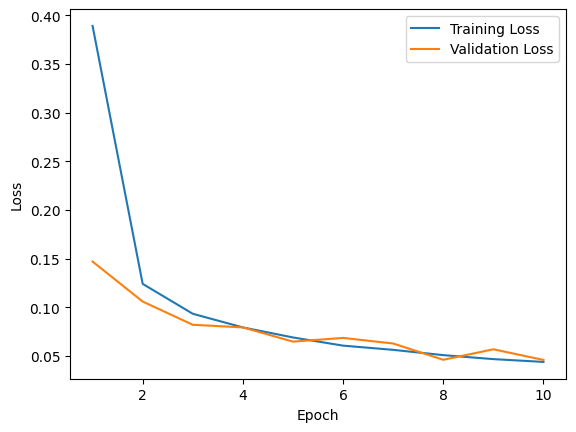

In [ ]:
# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


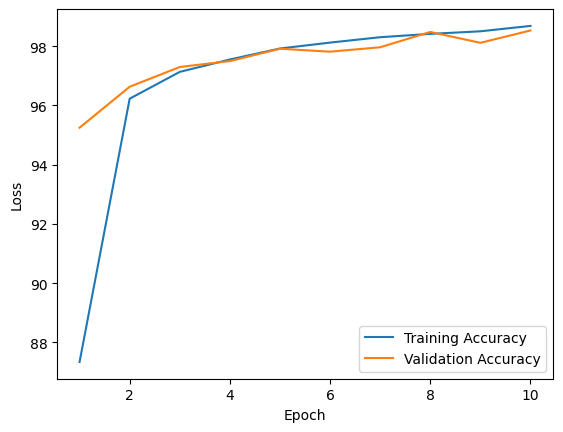

In [ ]:
# Plot the training and validation acc
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Accuracy:', accuracy)

Test Accuracy: 0.9875


In [ ]:
# Print Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1133    1    0    0    0    0    0    1    0]
 [   1    6 1015    2    2    0    1    3    2    0]
 [   1    0    3  994    0    7    0    2    3    0]
 [   1    2    0    0  970    0    1    1    2    5]
 [   1    0    0    1    0  885    1    1    3    0]
 [   3    3    0    0    3    1  946    0    2    0]
 [   0    3    5    0    0    1    0 1017    1    1]
 [   4    0    3    0    0    0    1    3  961    2]
 [   1    3    3    0    9    1    1   10    3  978]]


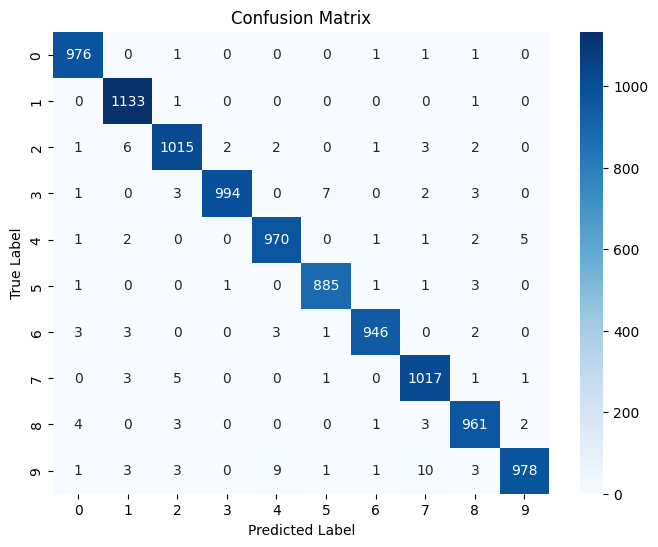

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Bonus: dealing with overfititng and improving performance.

we will try to implement two technique to deal with this problem

*   Batch Normalaisation : here we will normalize the inputs of each layer, which should improve generalization of the model
*   Early Stopping : if model starts to overfit after couple of epochs, we will reduce the traing cycles






In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(4)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(4 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
# model initialaization with  loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# list to store losses
train_losses = []
val_losses = []

new_epoch = 9

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=36, out_features=10, bias=True)
)


In [ ]:
# Training
for epoch in range(new_epoch):
    model.train()
    epoch_train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader, 1):
        labels = labels.view(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # if i % 100 == 0:
        #     print('Epoch',epoch + 1,'/',new_epoch, 'Step',i/len(train_loader),'Loss',loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1))
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print('Epoch' ,epoch + 1,'/',new_epoch, f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch 1 / 9 Training Loss: 0.3247, Validation Loss: 0.0870
Epoch 2 / 9 Training Loss: 0.0712, Validation Loss: 0.0672
Epoch 3 / 9 Training Loss: 0.0551, Validation Loss: 0.0562
Epoch 4 / 9 Training Loss: 0.0451, Validation Loss: 0.0558
Epoch 5 / 9 Training Loss: 0.0405, Validation Loss: 0.0599
Epoch 6 / 9 Training Loss: 0.0370, Validation Loss: 0.0487
Epoch 7 / 9 Training Loss: 0.0333, Validation Loss: 0.0532
Epoch 8 / 9 Training Loss: 0.0315, Validation Loss: 0.0504
Epoch 9 / 9 Training Loss: 0.0295, Validation Loss: 0.0442


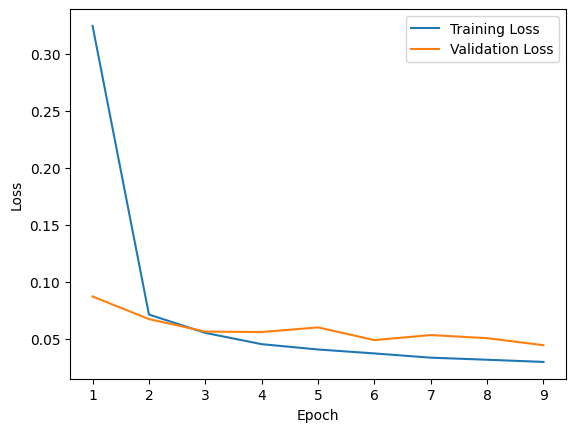

In [ ]:
# Plot the training and validation losses
plt.plot(range(1, new_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, new_epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Accuracy:', accuracy)

Test Accuracy: 0.988


# *Experiment Two*

In [ ]:
# preparing the data

# map the data into new classes
def class_mapping(label):
    mapping = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}
    combined_label = torch.tensor(mapping[label])
    return combined_label


# Modify the train_dataset and test_dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform, target_transform=class_mapping)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform, target_transform=class_mapping)

In [ ]:
# creating train test and validation

total_size = len(train_dataset)
train_size = int(0.9 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# modified cnn architeccure
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected output layer
        self.fc = nn.Linear(4 * 3 * 3, 4)  # Assuming the spatial size is reduced to 4x4 after convolution layers
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Print the size after the second convolutional layer
        # print("Size after Conv3',x.size())

        # Flatten the output before passing to fully connected layer
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        # Fully connected layer with softmax activation
        # x = self.softmax(x)
        return x


In [ ]:
# Initialization
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
train_acc  = []
val_acc = []

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=36, out_features=4, bias=True)
)


In [ ]:
# Training
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader, 1):
        labels = labels.view(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1))
            epoch_val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)

    print('Epoch', epoch + 1, '/', epochs, f'Training Loss: {avg_train_loss:.4f}, Training Acc: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')


Epoch 1 / 10 Training Loss: 0.2323, Training Acc: 91.83%, Validation Loss: 0.1035, Validation Acc: 96.63%
Epoch 2 / 10 Training Loss: 0.0867, Training Acc: 97.13%, Validation Loss: 0.0650, Validation Acc: 97.95%
Epoch 3 / 10 Training Loss: 0.0624, Training Acc: 97.98%, Validation Loss: 0.0719, Validation Acc: 97.70%
Epoch 4 / 10 Training Loss: 0.0515, Training Acc: 98.32%, Validation Loss: 0.0472, Validation Acc: 98.47%
Epoch 5 / 10 Training Loss: 0.0436, Training Acc: 98.58%, Validation Loss: 0.0374, Validation Acc: 98.72%
Epoch 6 / 10 Training Loss: 0.0395, Training Acc: 98.73%, Validation Loss: 0.0443, Validation Acc: 98.55%
Epoch 7 / 10 Training Loss: 0.0344, Training Acc: 98.91%, Validation Loss: 0.0438, Validation Acc: 98.65%
Epoch 8 / 10 Training Loss: 0.0320, Training Acc: 98.98%, Validation Loss: 0.0356, Validation Acc: 98.90%
Epoch 9 / 10 Training Loss: 0.0289, Training Acc: 99.04%, Validation Loss: 0.0361, Validation Acc: 98.92%
Epoch 10 / 10 Training Loss: 0.0275, Training 

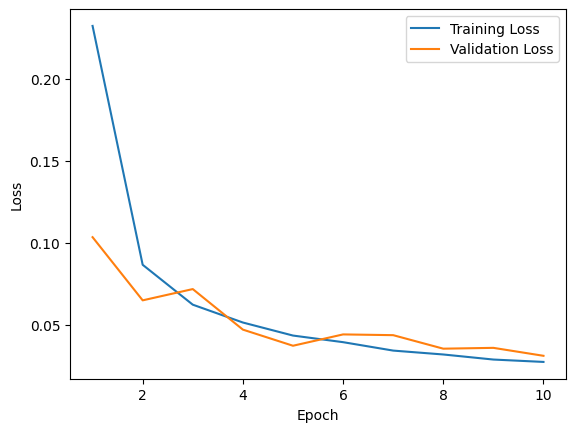

In [ ]:
# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

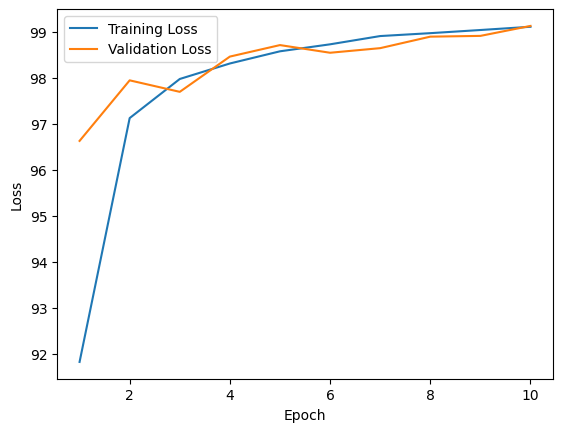

In [ ]:
# Plot the training and validation Acc
plt.plot(range(1, epochs + 1), train_acc, label='Training Loss')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluation with modified classes
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels_transformed = []
mapping = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels_transformed.extend([mapping[label.item()] for label in labels])
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == torch.tensor(true_labels_transformed[-labels.size(0):])).sum().item()

accuracy = correct / total
print('Test Accuracy',accuracy)


Test Accuracy 0.9915


In [ ]:
# Print Confusion Matrix
conf_matrix = confusion_matrix(true_labels_transformed, predicted_labels, labels=[0, 1, 2, 3])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1918    5   11    4]
 [   0 2150   11    2]
 [  12   12 3878    6]
 [   4    6   12 1969]]


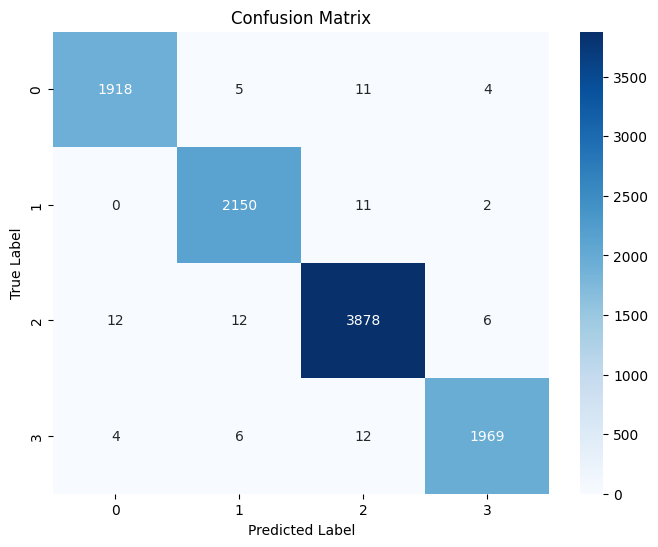

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()